In [1]:
import os

import re

import string

import random

import sklearn

import numpy as np

import pandas as pd

import seaborn as sns

from PIL import Image

from tqdm import tqdm

import lightgbm as lgbm

import missingno as msno

from sklearn.svm import SVC

import plotly.express as px

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.utils import shuffle


!pip install catboost
from catboost import CatBoostClassifier

from matplotlib.ticker import FuncFormatter

from sklearn.metrics import RocCurveDisplay

from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelBinarizer

from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, auc, accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(color_codes = True)

sns.set_palette(palette = 'gist_heat', n_colors = 8)

sns.set(style="whitegrid")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [2]:
# loading the dataset to a Pandas DataFrame
wine_dataset = pd.read_csv('/content/winequality-red.csv')

In [3]:
# number of rows & columns in the dataset
wine_dataset.shape

(1599, 12)

In [4]:
# checking for missing values
wine_dataset.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
# first 5 rows of the dataset
wine_dataset.sample(5)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
339            12.5              0.28         0.54             2.3      0.082   
1196            7.9              0.58         0.23             2.3      0.076   
213             8.2              0.57         0.26             2.2      0.060   
488            11.6              0.32         0.55             2.8      0.081   
714             9.9              0.74         0.28             2.6      0.078   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
339                  12.0                  29.0  0.99970  3.11       1.36   
1196                 23.0                  94.0  0.99686  3.21       0.58   
213                  28.0                  65.0  0.99590  3.30       0.43   
488                  35.0                  67.0  1.00020  3.32       0.92   
714                  21.0                  77.0  0.99800  3.28       0.51   

      alcohol  quality  
339       9.8        7  
1196      9.5        6  
213      10.1        5  
488      10.8        7  
714       9.8        5

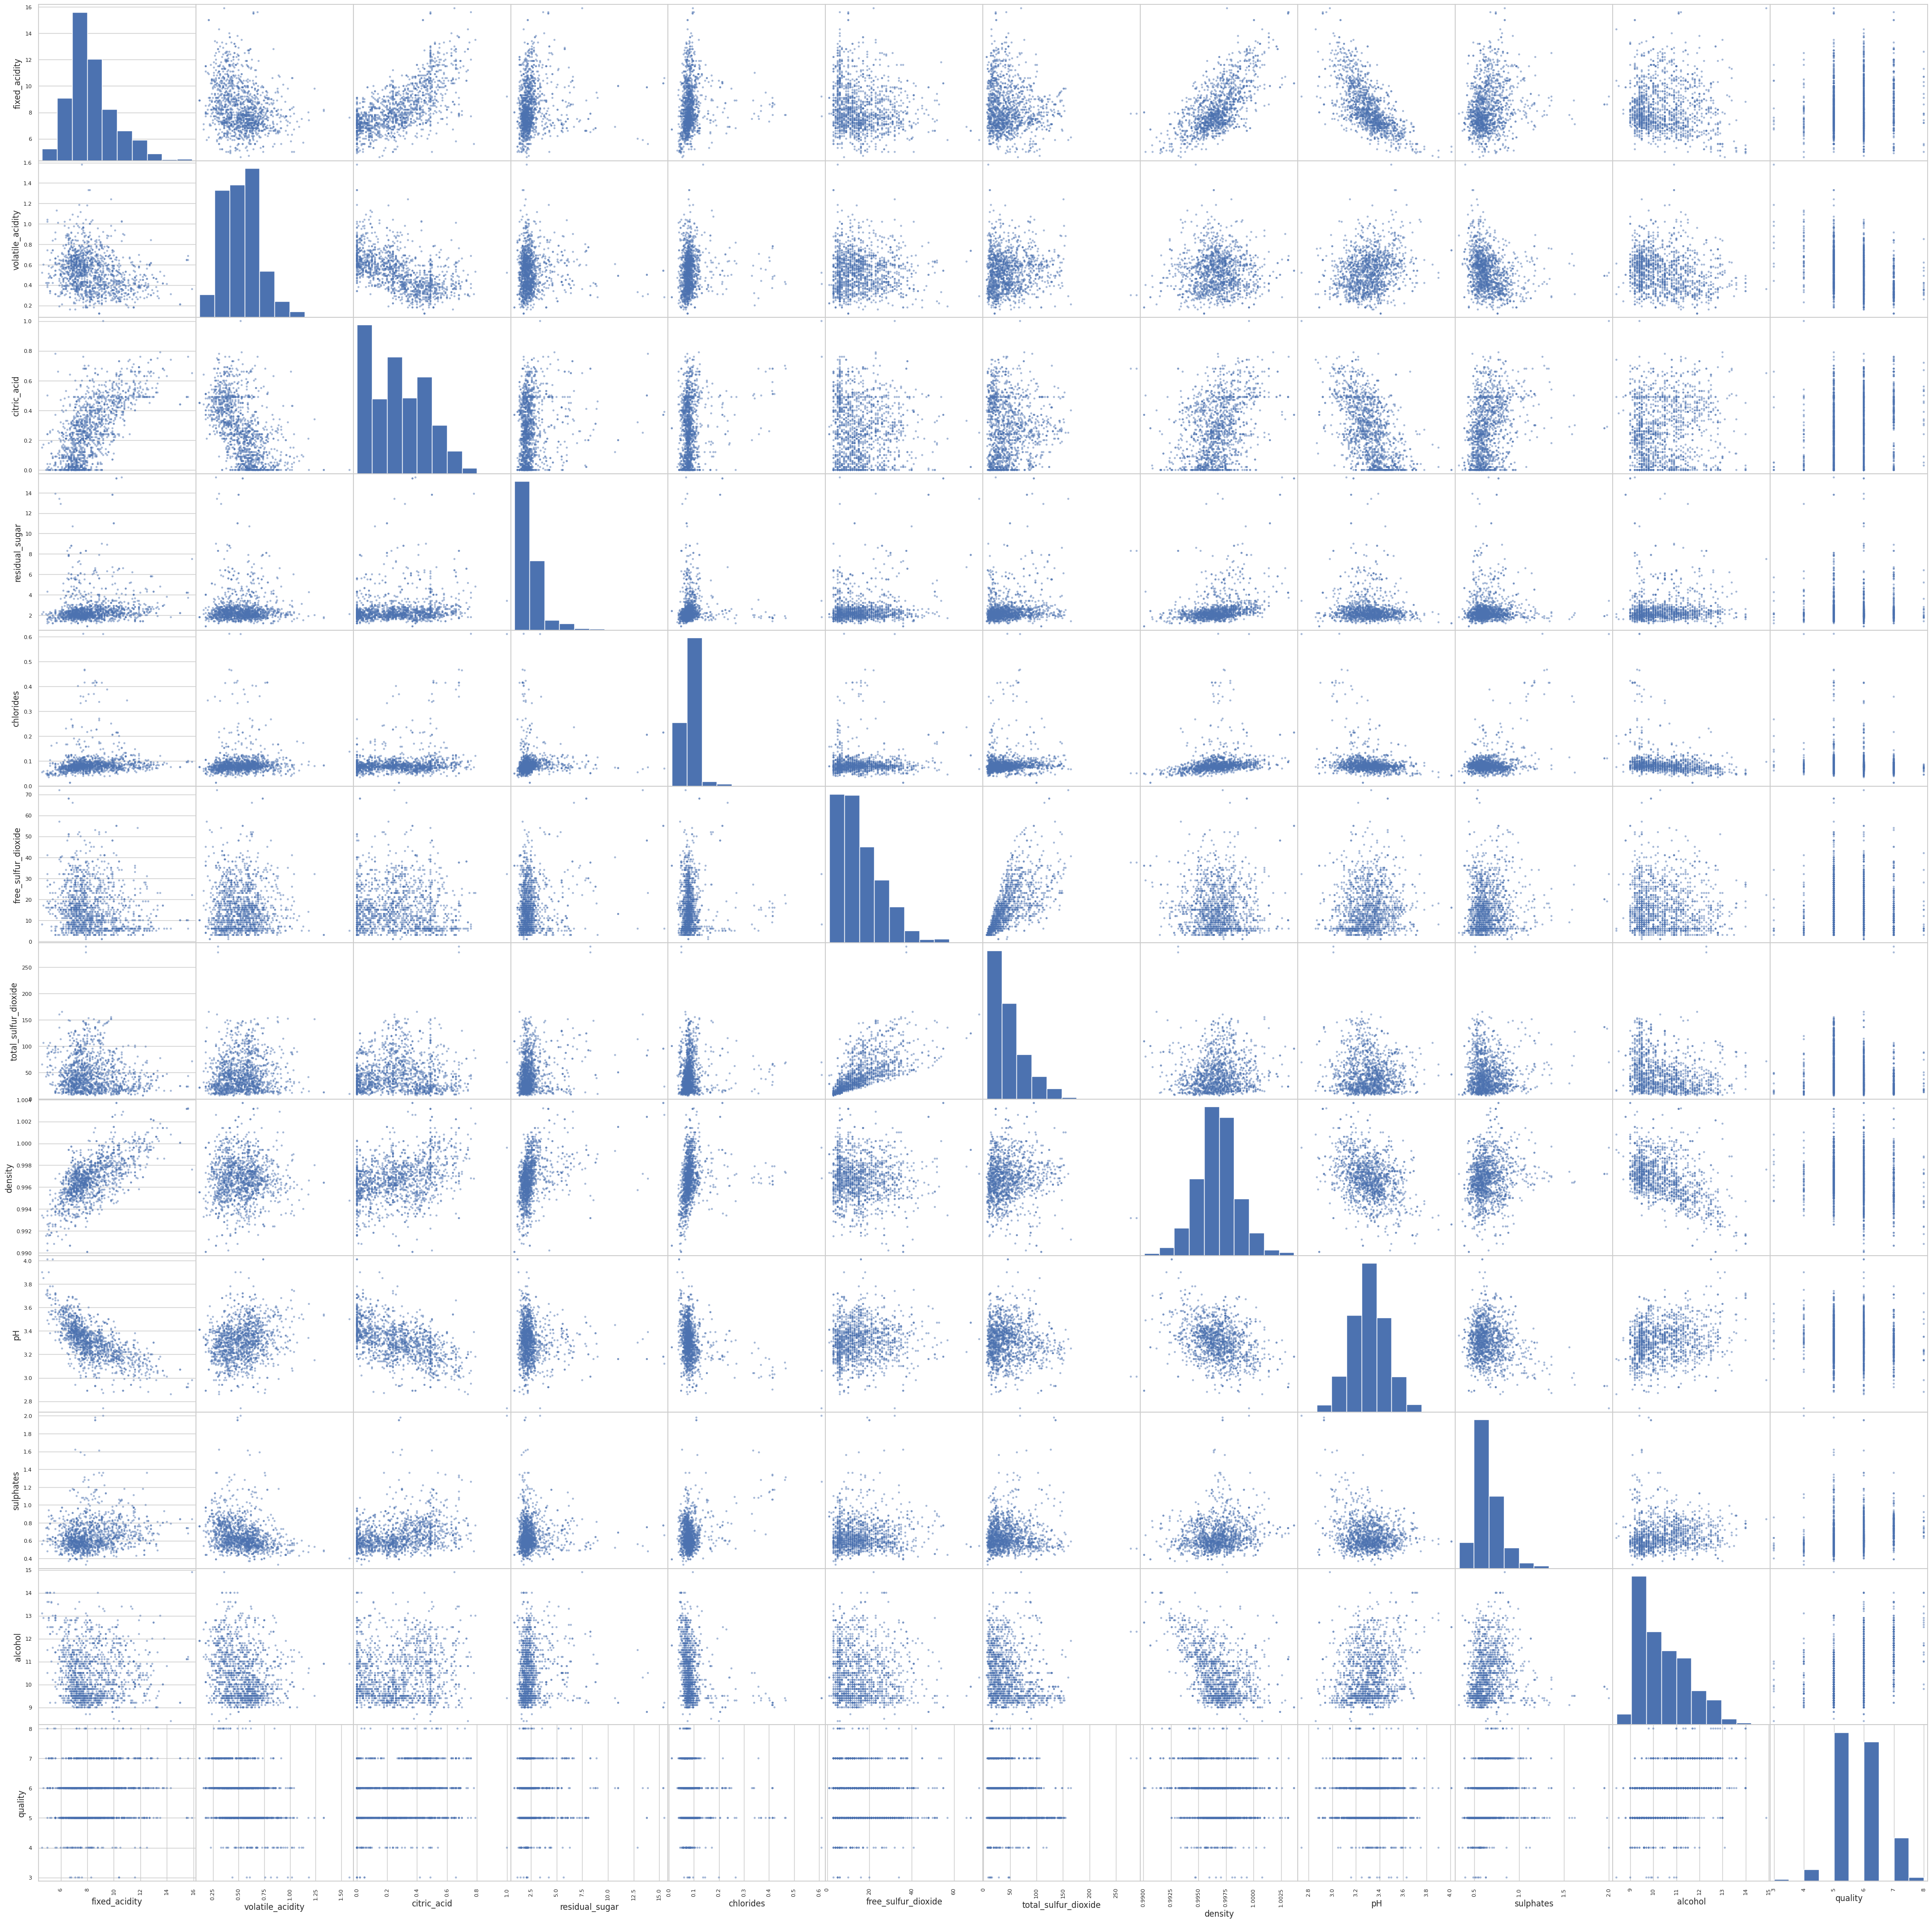

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(wine_dataset, figsize=(50, 50), diagonal='hist')

# Show the plot
plt.show()

In [7]:
# statistical measures of the dataset
wine_dataset.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc9c8777460>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc9c87779a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc9c872a650>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc9c8777ee0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc9c8776170>,
 'means': []}

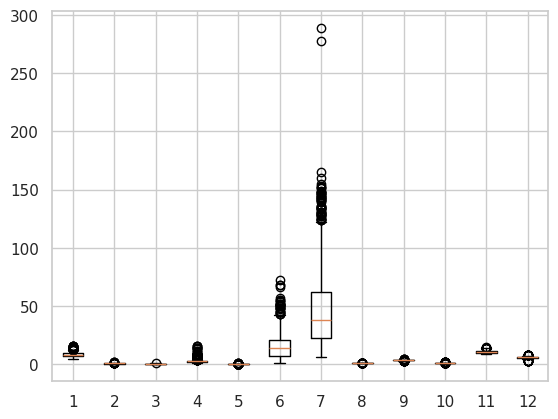

In [8]:
plt.boxplot(wine_dataset)

Remove the extermely large outliers

In [9]:
def remove_outliers(wine_dataset, threshold=3, iqr_multiplier=2.5):

    wine_dataset_final = wine_dataset.copy()

    for column in wine_dataset.select_dtypes(include=[np.number]).columns:
        data = wine_dataset_final[column]

        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR


        outliers = ((data < lower_bound) | (data > upper_bound)).sum()
        total_data_points = len(data)
        outlier_percentage = (outliers / total_data_points) * 100


        if outlier_percentage < threshold:
            wine_dataset_final = wine_dataset_final[(data >= lower_bound) & (data <= upper_bound)]

    return wine_dataset_final


In [10]:
wine_dataset_final = remove_outliers(wine_dataset)
wine_dataset_final.shape


(1551, 12)

In [11]:
Y = wine_dataset_final['quality']

wine_dataset_final = wine_dataset_final.drop(columns=['quality'])

In [12]:
def cap_outliers(wine_dataset_final, iqr_multiplier=1.5):

    for column in wine_dataset_final.select_dtypes(include=[np.number]).columns:
        data = wine_dataset_final[column]

        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        wine_dataset_final[column] = np.clip(data, lower_bound, upper_bound)

    return wine_dataset_final



In [13]:
wine_dataset_final = cap_outliers(wine_dataset_final)
wine_dataset_final.shape


(1551, 11)

# classification Models

In [19]:
Y = Y.replace({
    8: 'Good',
    7: 'Good',
    6: 'Middle',
    5: 'Middle',
    4: 'Bad',
    3: 'Bad'
})


print("Original Value Counts:")
print(Y.value_counts())

label_mapping = {'Bad': 0, 'Middle': 1, 'Good': 2}
Y = Y.map(label_mapping)

print("\nEncoded Value Counts:")
print(Y.value_counts())

print("\nUnique Encoded Labels:", Y.unique())


Original Value Counts:
quality
Middle    1280
Good       211
Bad         60
Name: count, dtype: int64

Encoded Value Counts:
quality
1    1280
2     211
0      60
Name: count, dtype: int64

Unique Encoded Labels: [1 2 0]


In [21]:
X = wine_dataset_final.values


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 0, stratify = Y)

print(X_train.shape)

print( X_test.shape)

print(y_train.shape)

print(y_test.shape)

Shape of X_train:  (1318, 11)
Shape of X_test:  (233, 11)
Shape of y_train:  (1318,)
Shape of y_test (233,)


In [23]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)
#Flattened array
y_train = y_train.ravel()

y_test = y_test.ravel()

In [28]:
al = []
accuracy = []
models = []

def evaluate_model(algorithm_name, model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)


    acc_model = model.score(X_test, y_test)
    train_acc_model = model.score(X_train, y_train)


    al.append(algorithm_name)
    accuracy.append(acc_model)

    print('\033[31m' + f'For {algorithm_name}' + '\033[0m\n')
    print(f'Training Accuracy: {train_acc_model * 100:.4f} %\n')
    print(f'Testing Accuracy: {acc_model * 100:.4f} %\n')
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.4f} %\n')

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    plt.subplot(1, 2, 1)
    fig.suptitle(f'Graphs for {algorithm_name}', fontsize=25)


    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
                cmap='RdGy', annot_kws={'size': 15},
                square=True, fmt='.0f',
                ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=20)

    plt.subplot(1, 2, 2)
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'Class {i} (AUC = {roc:.2f})', color='red')

    axes[1].set_xlabel('False Positive Rate', fontsize=15)
    axes[1].set_ylabel('True Positive Rate', fontsize=15)
    axes[1].set_title(f'ROC Curves for Multiclass', fontsize=20)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    if algorithm_name != 'K Nearest Neighbors':
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

        feature_importance = perm_importance.importances_mean

        feature_names = wine_dataset_final.columns

        plt.figure(figsize=(12, 6))
        plt.barh(feature_names, feature_importance, color='#b40000')
        plt.xlabel('Permutation Importance')
        plt.ylabel('Feature')
        plt.title('Permutation Importance for Features')
        plt.show()


    cm = confusion_matrix(y_test, y_pred)
    tp = cm[0, 0] if cm.shape[0] > 1 else 0
    fp = cm[0, 1] if cm.shape[1] > 1 else 0
    tn = cm[1, 1] if cm.shape[0] > 1 else 0
    fn = cm[1, 0] if cm.shape[1] > 1 else 0


    models.append((algorithm_name, tp, fp, tn, fn, train_acc_model, acc_model))


For Logistic Regression

Training Accuracy: 84.6737 %

Testing Accuracy: 84.1202 %

Accuracy Score: 84.1202 %



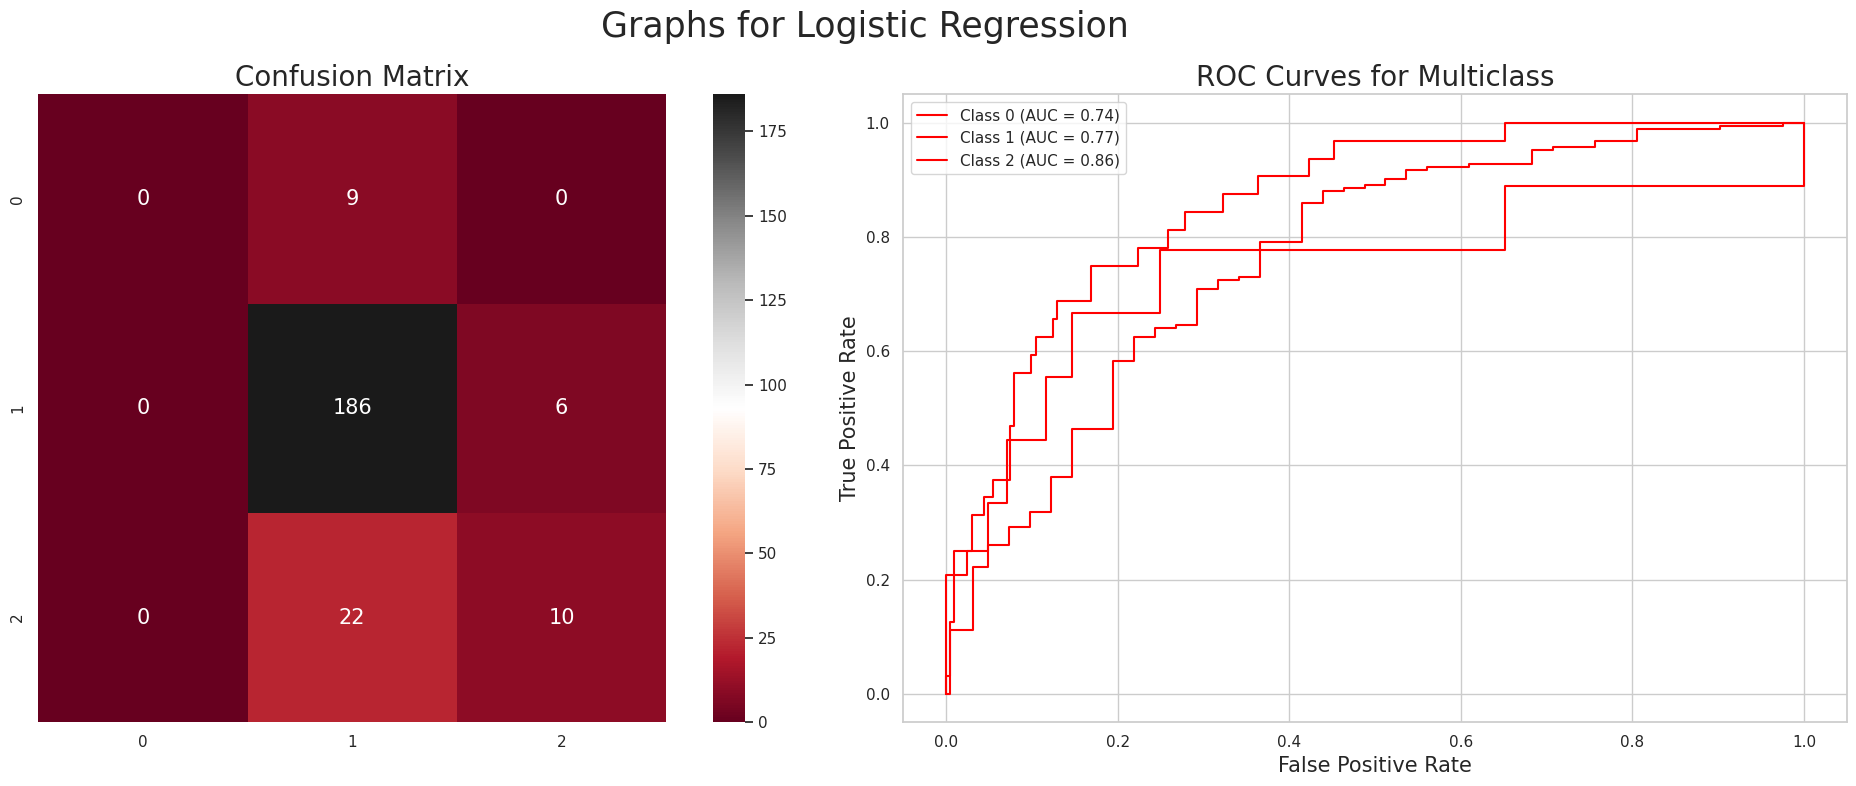

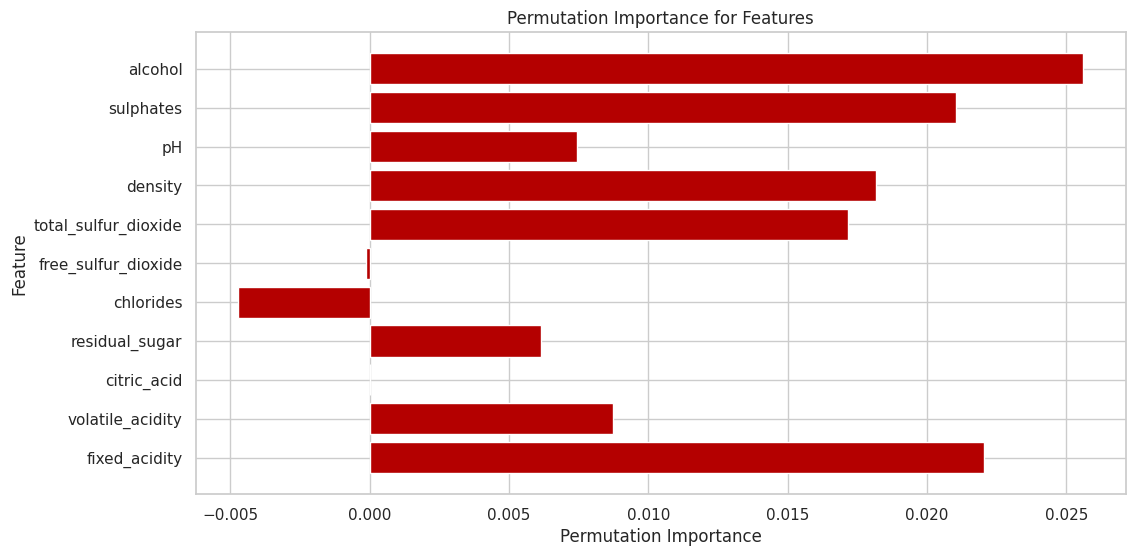

In [29]:
evaluate_model('Logistic Regression',

                           LogisticRegression(C=1.2, fit_intercept=True,

                                              max_iter=50, penalty = 'l1', solver='saga'))

For Decision Tree Classifier

Training Accuracy: 100.0000 %

Testing Accuracy: 85.8369 %

Accuracy Score: 85.8369 %



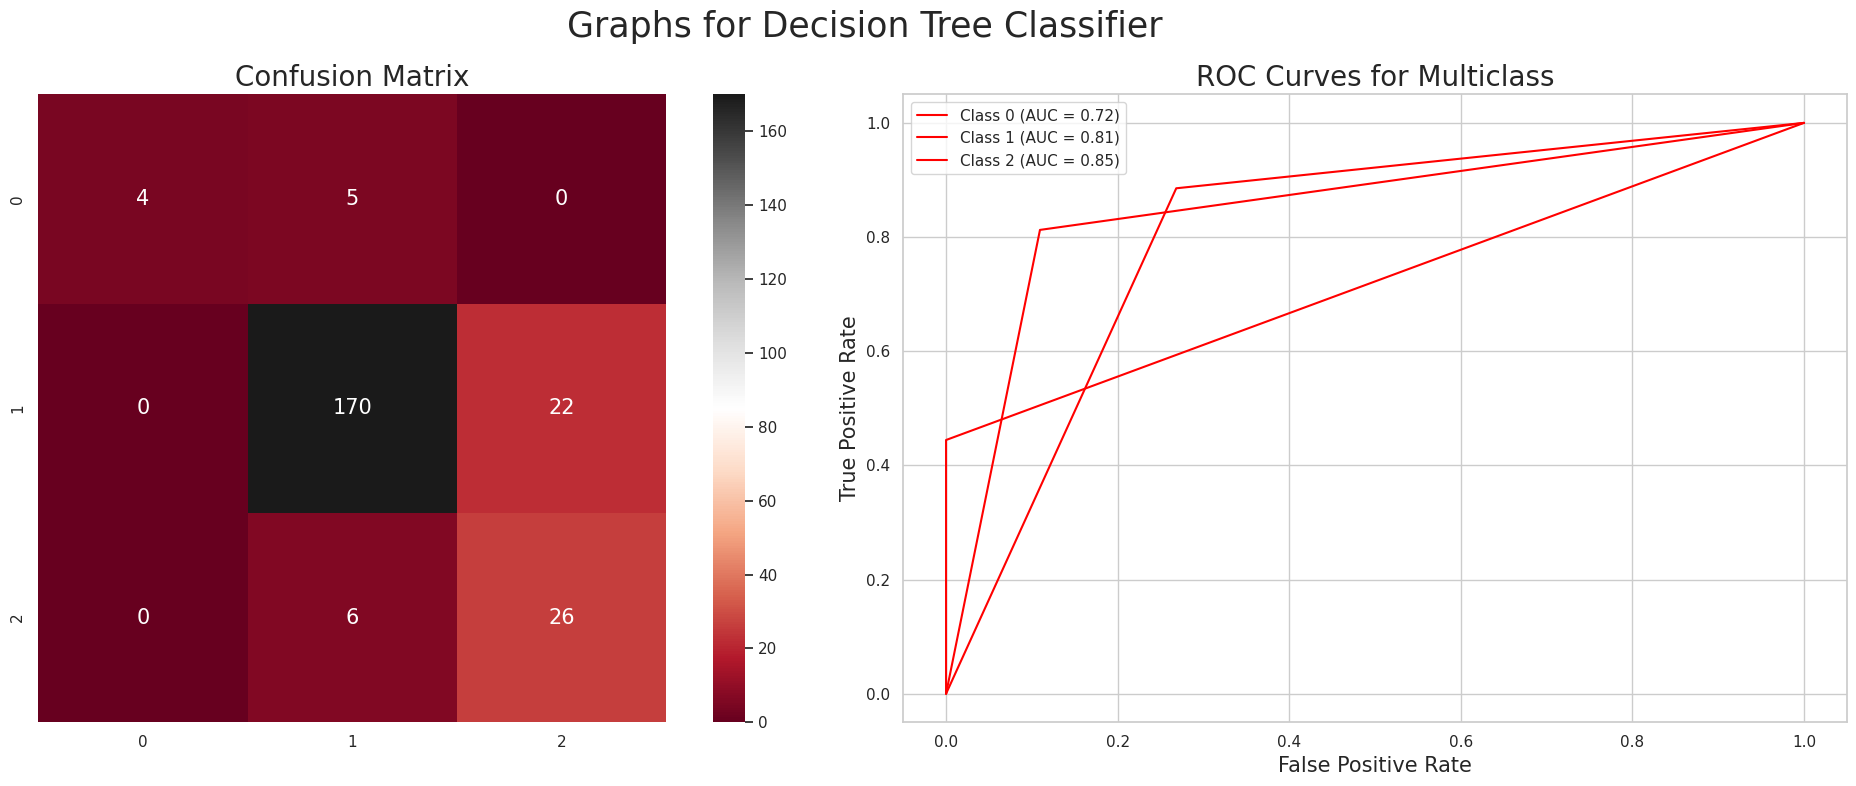

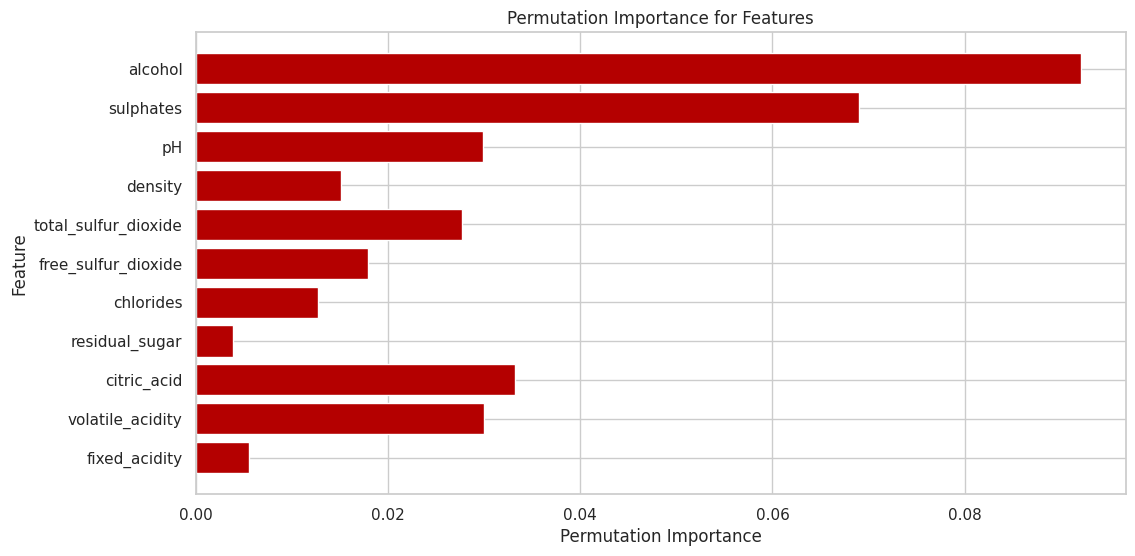

In [34]:
evaluate_model('Decision Tree Classifier',

               DecisionTreeClassifier(criterion = 'entropy',

                                      splitter = 'best',

                                      max_features=6, max_depth = 20,

                                      max_leaf_nodes=200, random_state = 33))

For Random Forest Classifer

Training Accuracy: 100.0000 %

Testing Accuracy: 87.9828 %

Accuracy Score: 87.9828 %



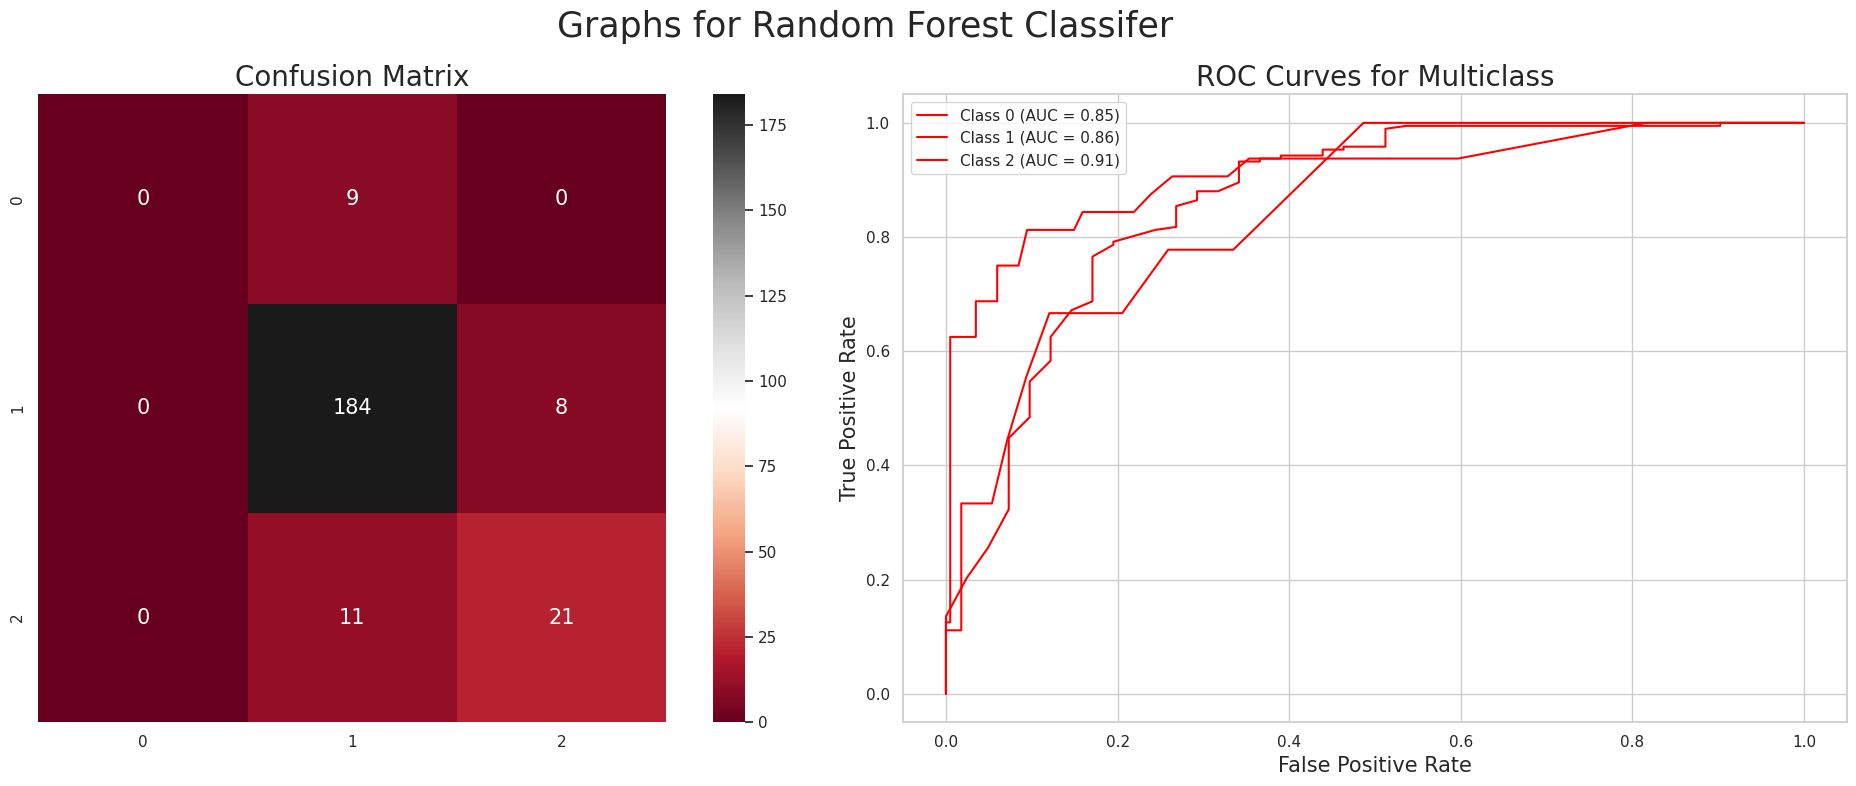

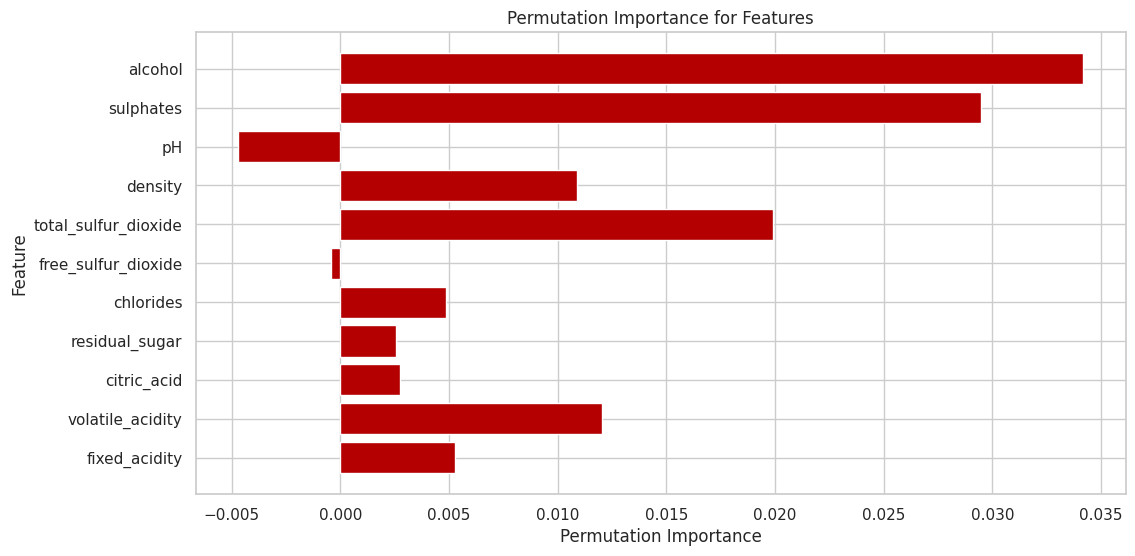

In [35]:
evaluate_model('Random Forest Classifer',

               RandomForestClassifier(criterion = 'gini', max_depth = 30,

                                      max_features ='sqrt', n_estimators = 100,

                                      random_state = 33))

For Support Vector Classifier

Training Accuracy: 86.7982 %

Testing Accuracy: 86.6953 %

Accuracy Score: 86.6953 %



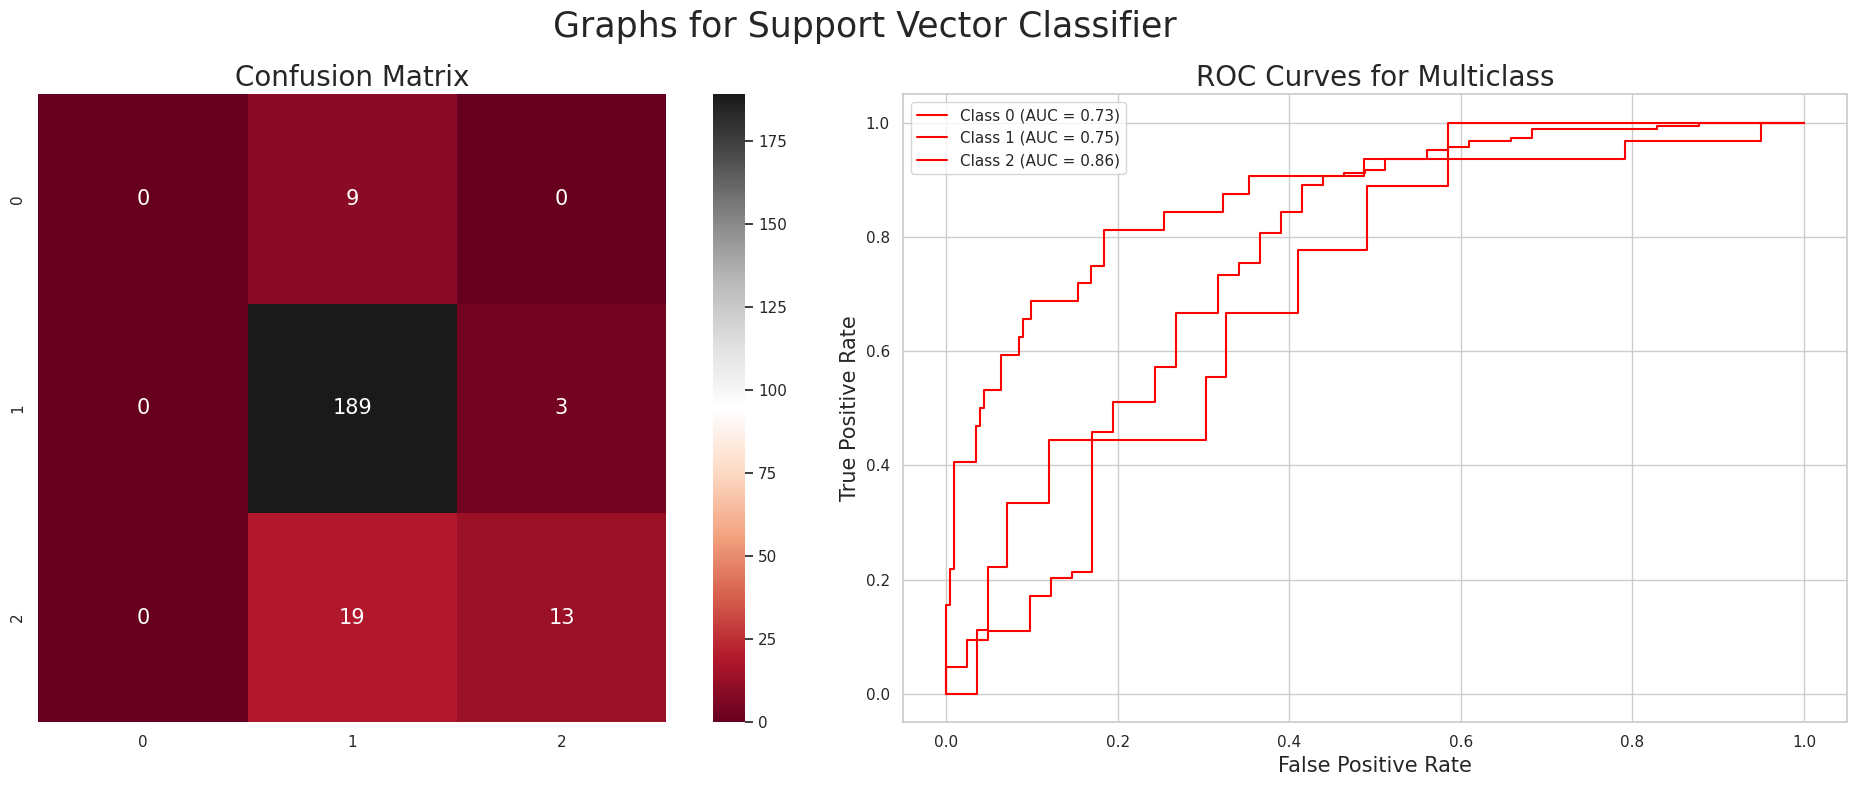

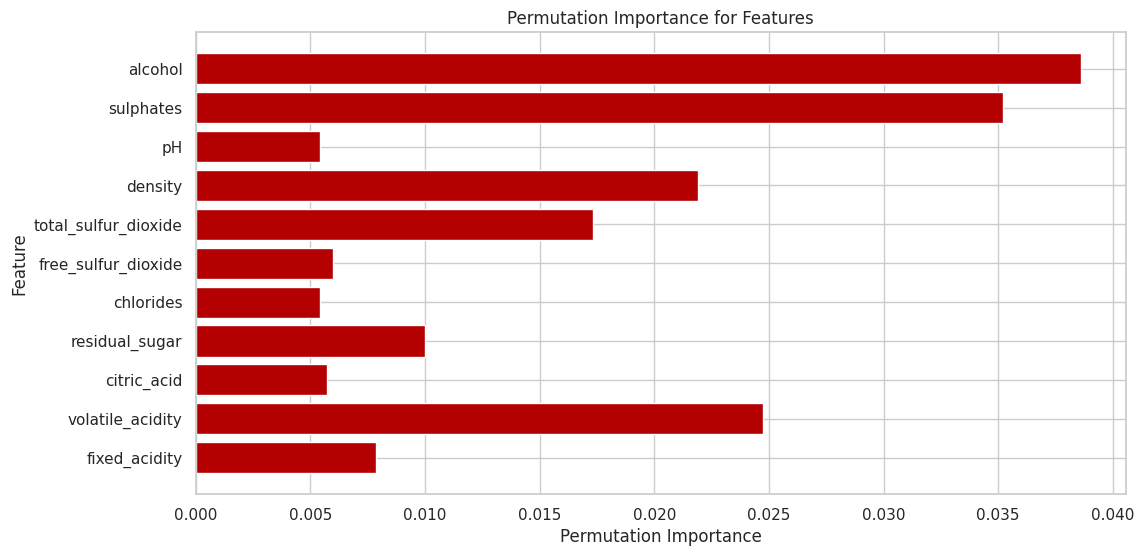

In [36]:
evaluate_model('Support Vector Classifier', SVC( C = 1, gamma = 'auto',

                                                kernel = 'rbf', random_state = 33, probability=True))

For K Nearest Neighbors

Training Accuracy: 100.0000 %

Testing Accuracy: 88.4120 %

Accuracy Score: 88.4120 %



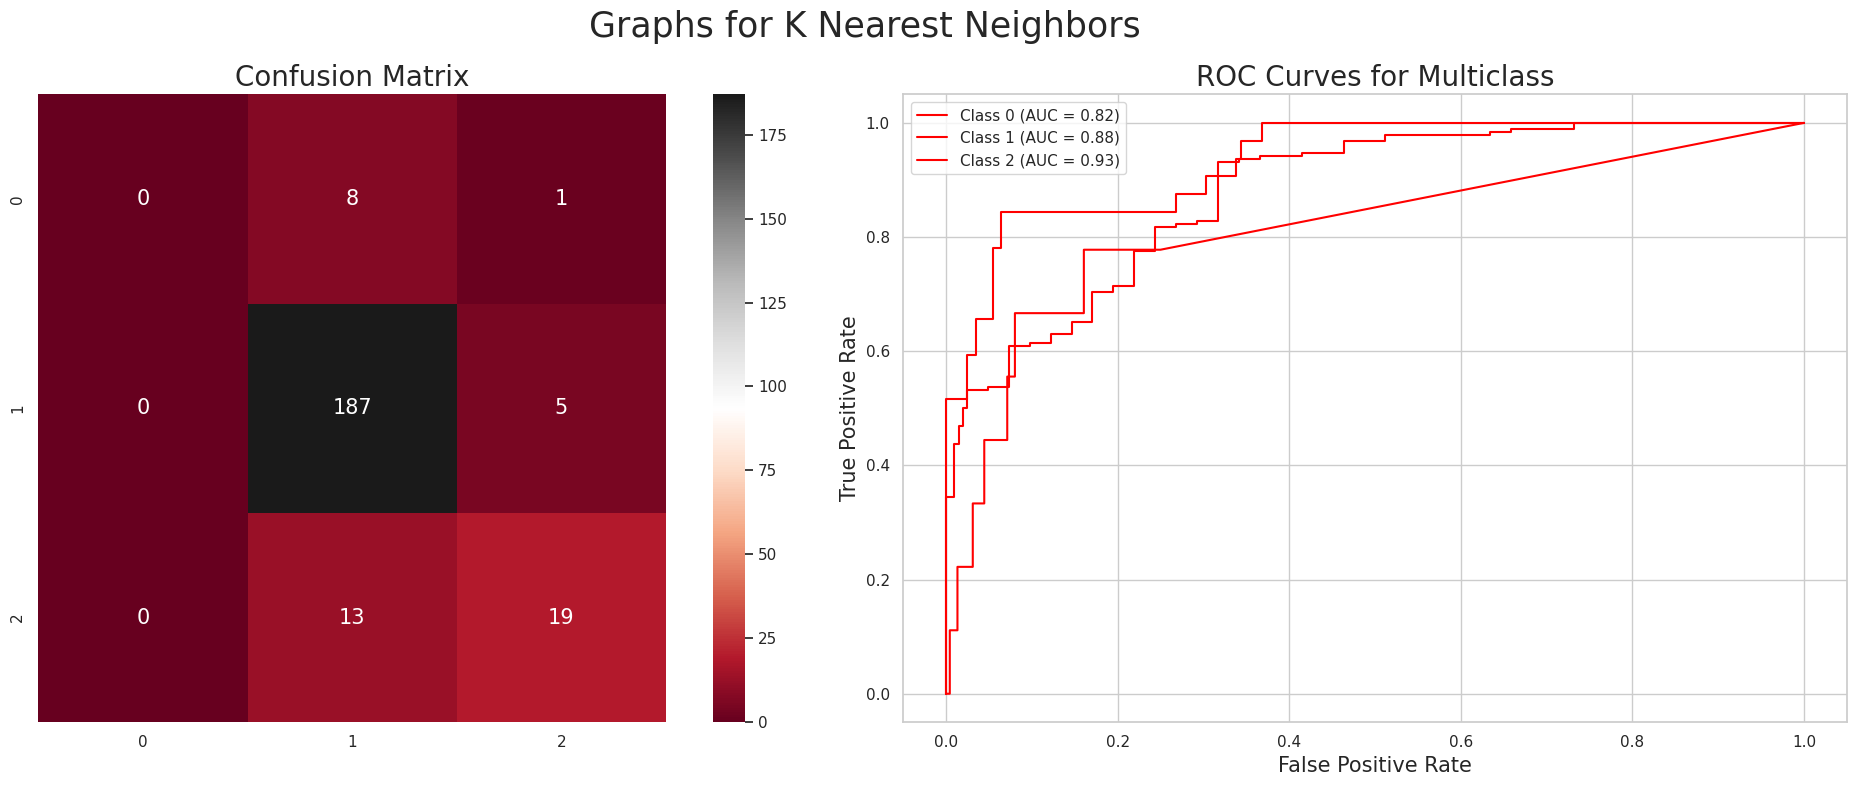

In [37]:
evaluate_model('K Nearest Neighbors',

               KNeighborsClassifier(algorithm = 'auto',

                                    leaf_size = 20, metric = 'euclidean',

                                    n_jobs = -1, n_neighbors = 25, p = 2,

                                    weights = 'distance'))

In [38]:
GradientBoostingClassifier(

    loss='deviance',

    learning_rate=0.2,

    max_depth=5,

    min_samples_split=5,

    min_samples_leaf=2,

    subsample=1.0,

    n_estimators=60,

    random_state=33)

GradientBoostingClassifier(learning_rate=0.2, loss='deviance', max_depth=5,
                           min_samples_leaf=2, min_samples_split=5,
                           n_estimators=60, random_state=33)

For Gradient Boosting Classifier

Training Accuracy: 100.0000 %

Testing Accuracy: 88.8412 %

Accuracy Score: 88.8412 %



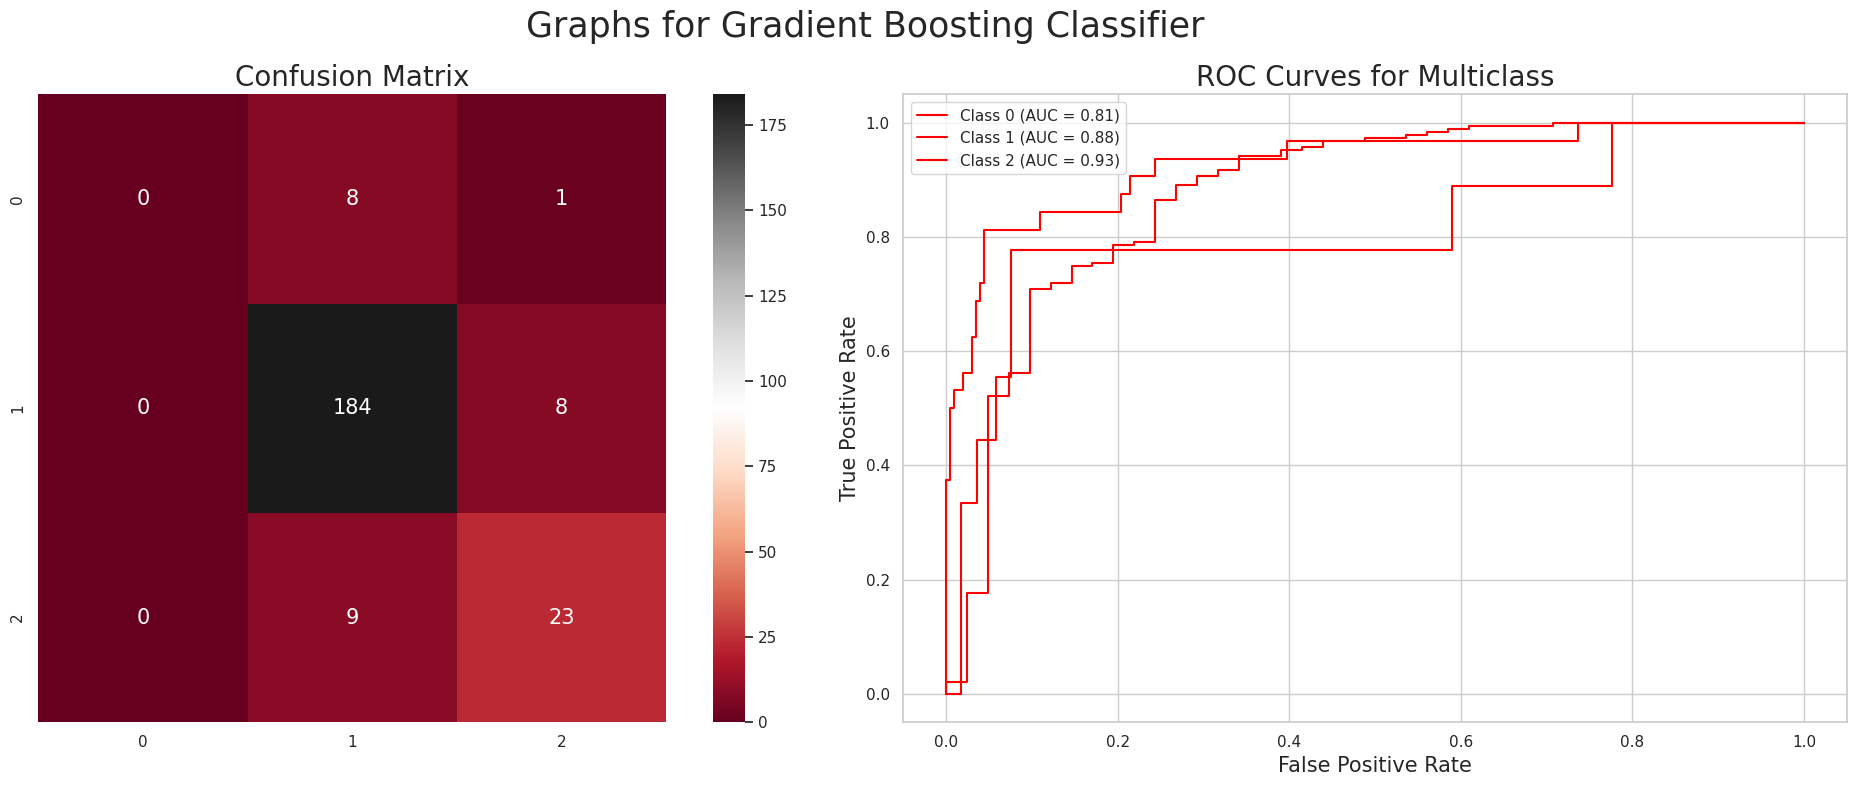

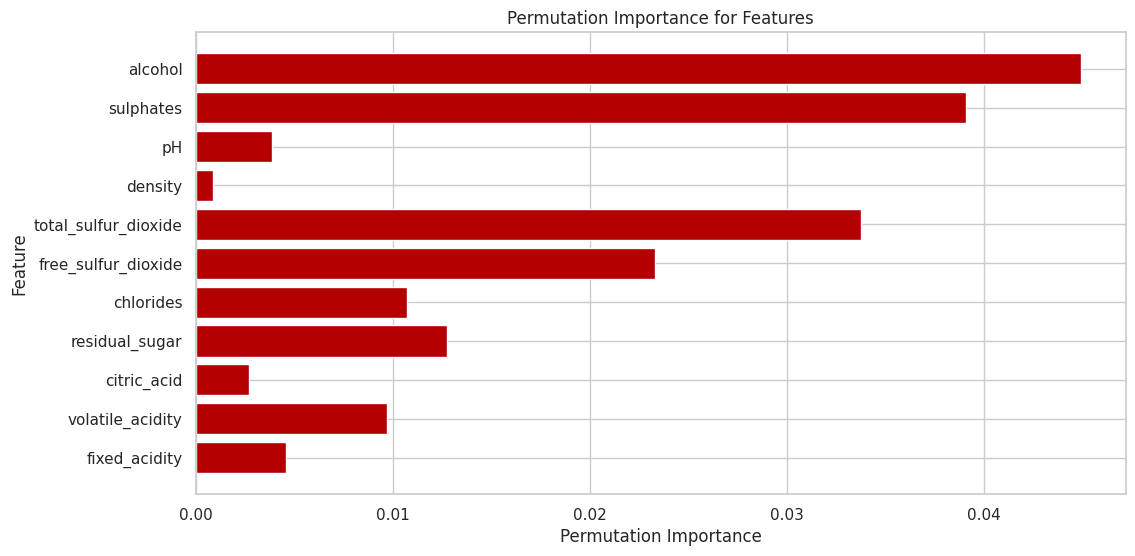

In [39]:
evaluate_model('Gradient Boosting Classifier',

               GradientBoostingClassifier( loss = 'log_loss',learning_rate = 0.2, max_depth = 5,

                                          min_samples_split = 5, min_samples_leaf = 2,

                                          subsample= 1.0,

                                          n_estimators = 60, random_state = 33))

For XGBoost Classifier

Training Accuracy: 100.0000 %

Testing Accuracy: 88.8412 %

Accuracy Score: 88.8412 %



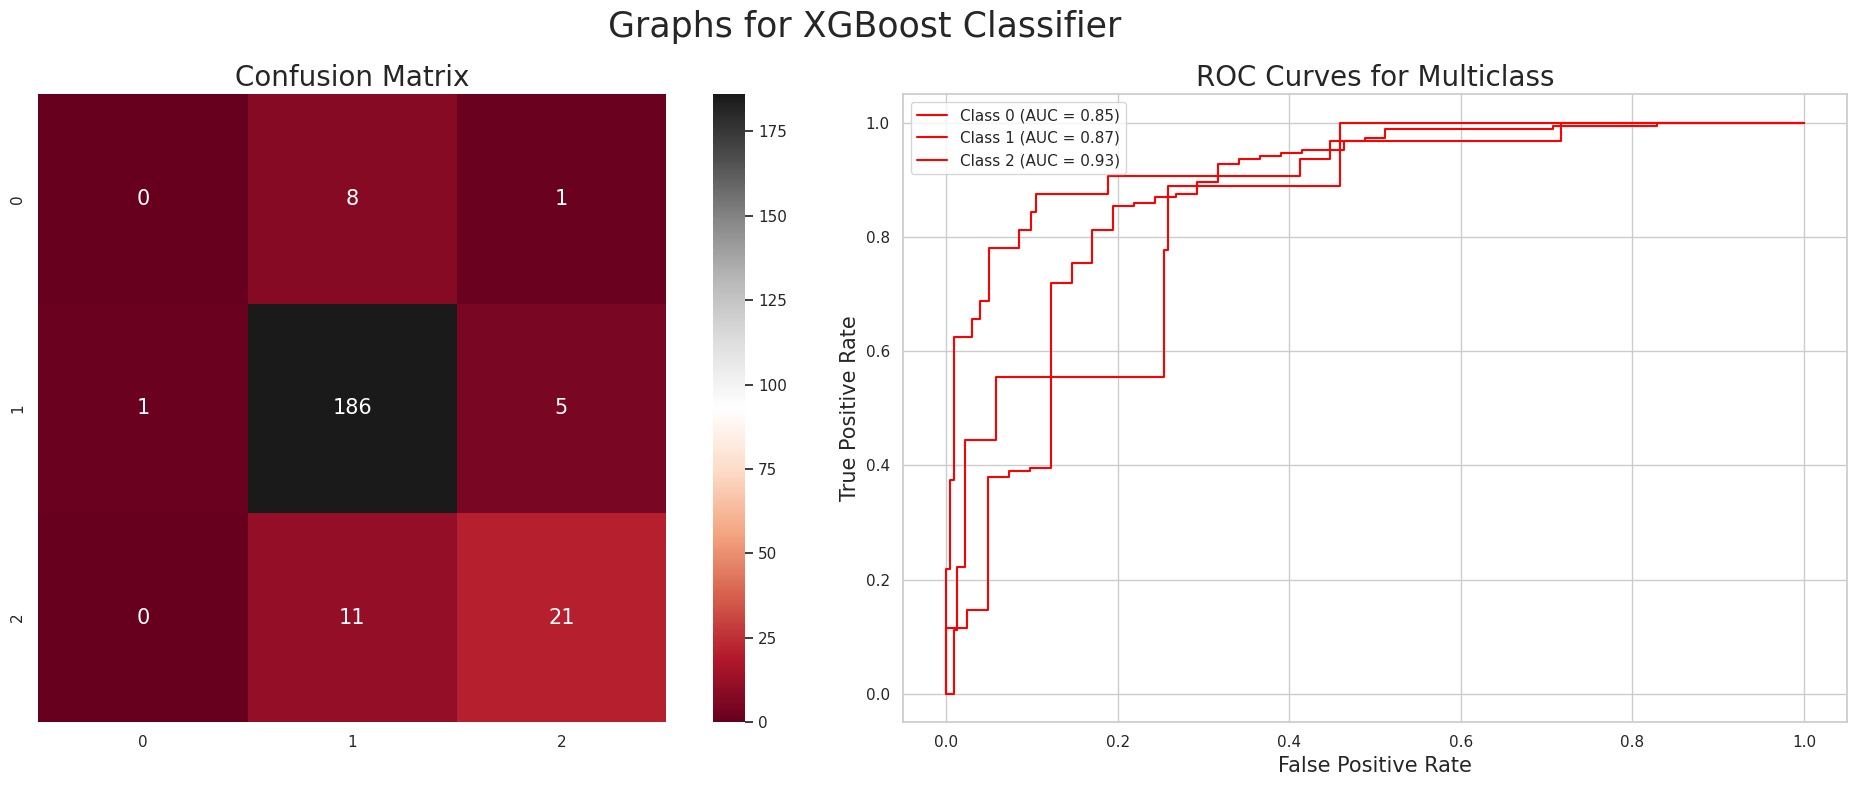

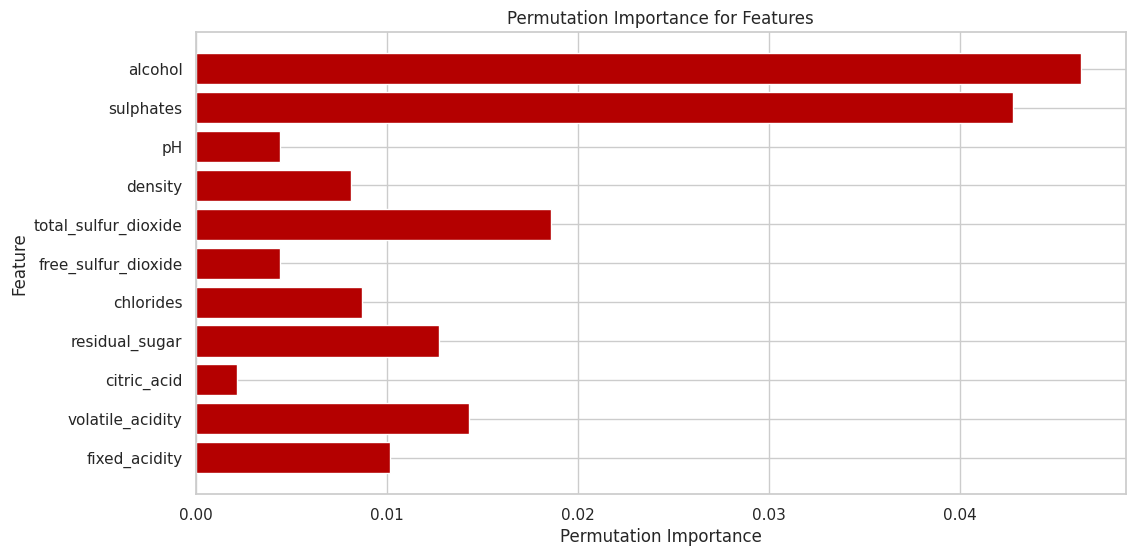

In [40]:
evaluate_model('XGBoost Classifier', XGBClassifier(

    booster='gbtree',

    gamma = 0.09,

    learning_rate=0.15,

    n_estimators=200,

    max_depth=13,

    min_child_weight=1,

    subsample=0.8,

    colsample_bytree=0.8,

    objective='binary:logistic',

    random_state=33))

For Light Gradient Boosting Machine

Training Accuracy: 100.0000 %

Testing Accuracy: 87.5536 %

Accuracy Score: 87.5536 %



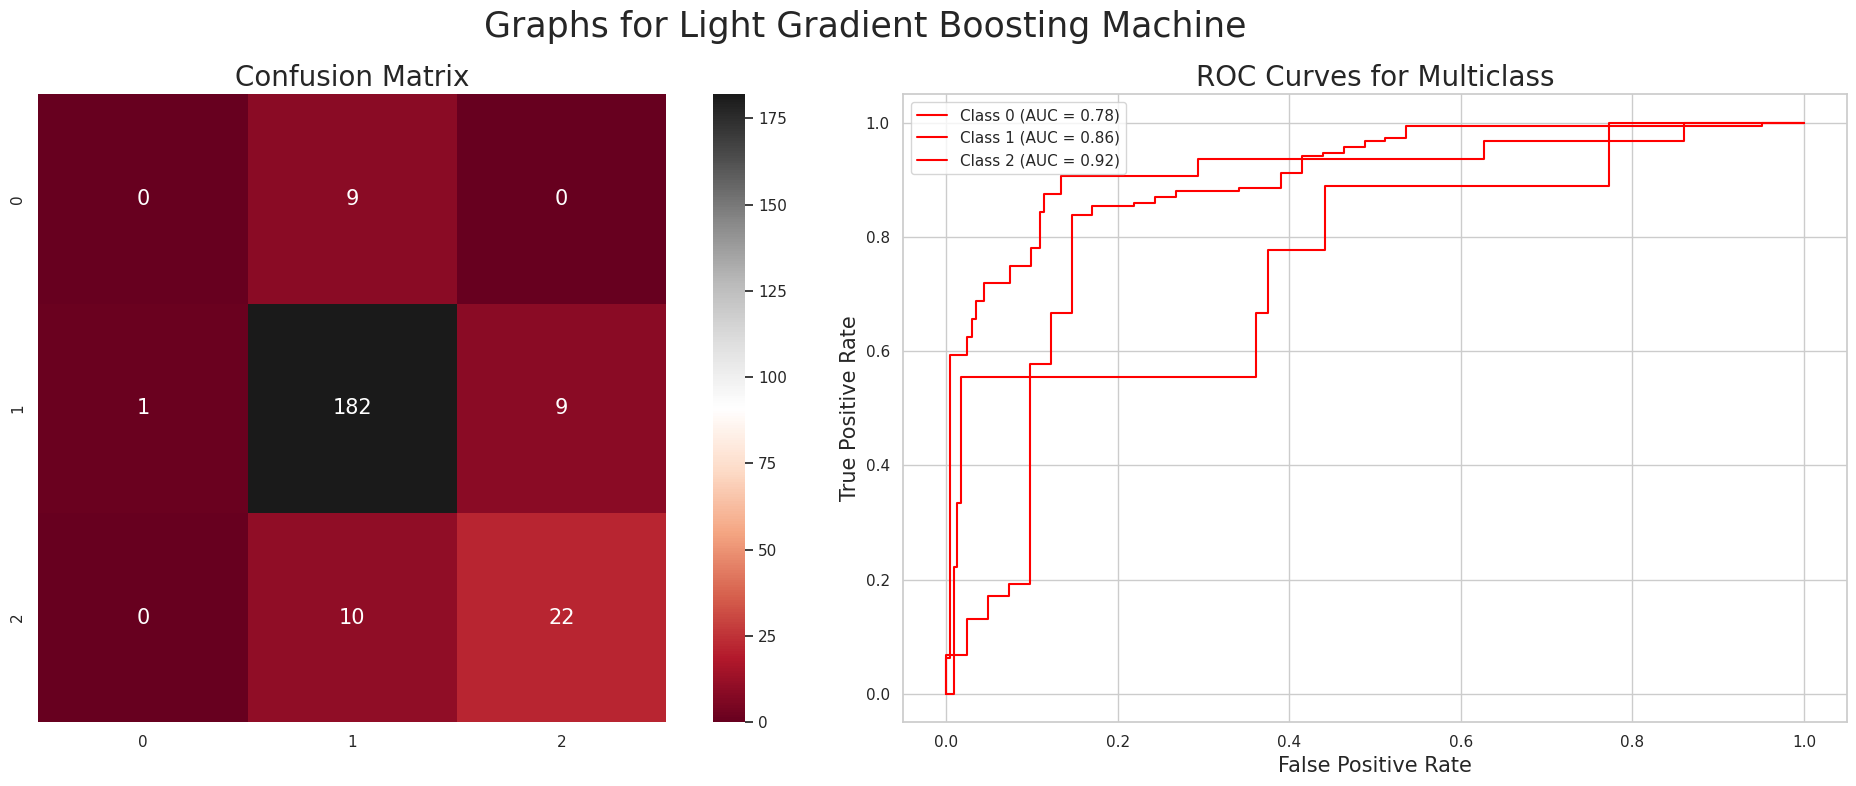

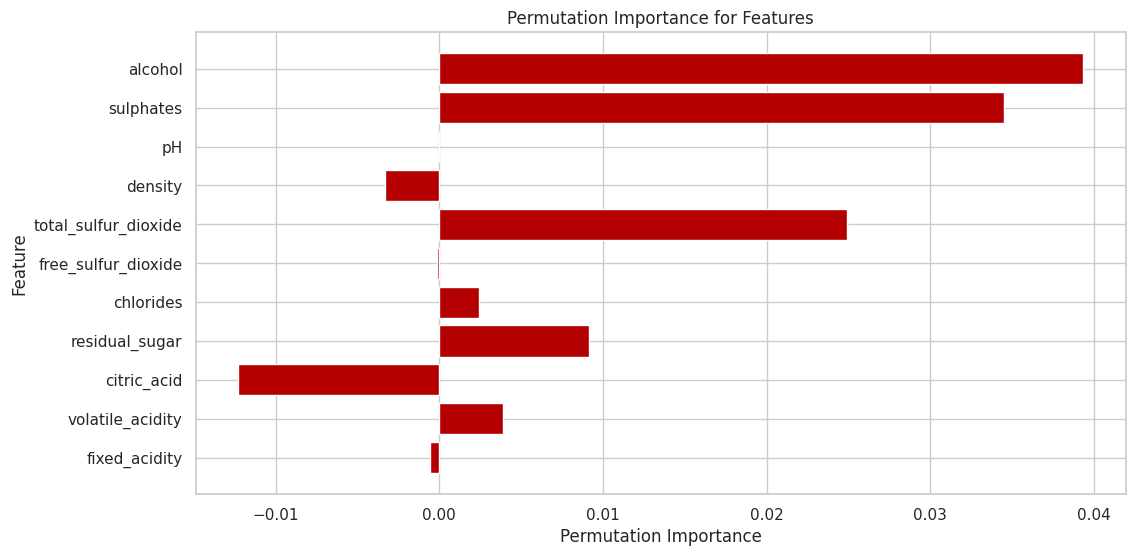

In [41]:
evaluate_model('Light Gradient Boosting Machine', lgbm.LGBMClassifier(

    boosting_type='gbdt',

    learning_rate=0.1,

    n_estimators=110,

    max_depth=15,

    num_leaves = 40,

    min_child_weight = 1,

    subsample=0.8,

    colsample_bytree=0.8,

    reg_alpha = 0.0,

    reg_lambda = 0.1,

    random_state=33,

    verbose=-1))

For AdaBoost Classifier

Training Accuracy: 84.8255 %

Testing Accuracy: 86.2661 %

Accuracy Score: 86.2661 %



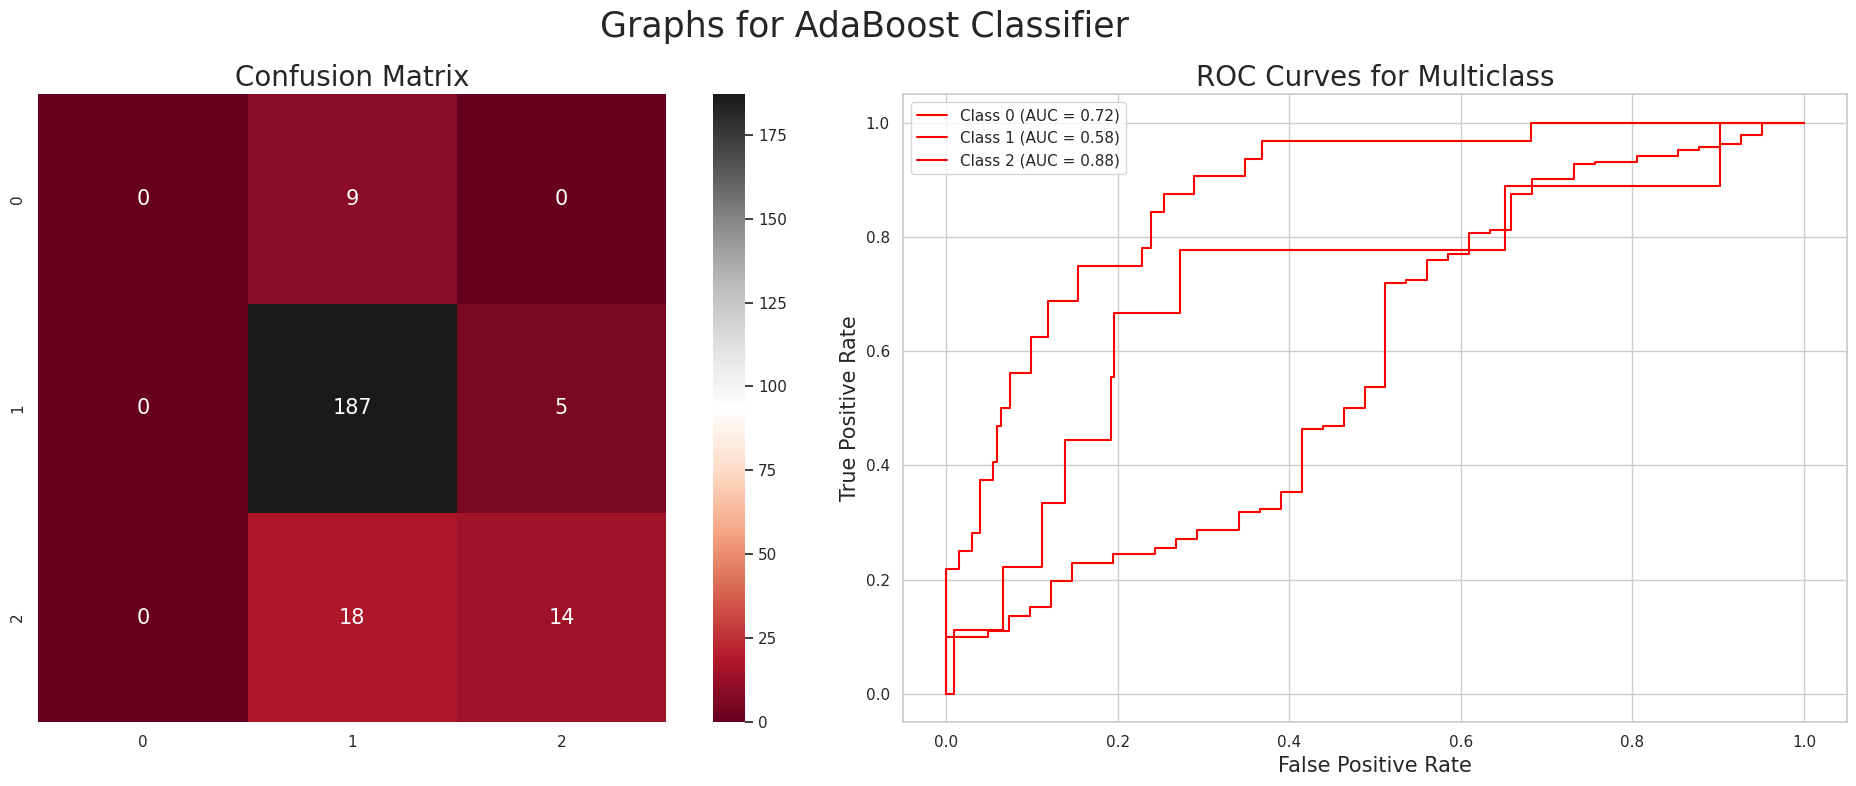

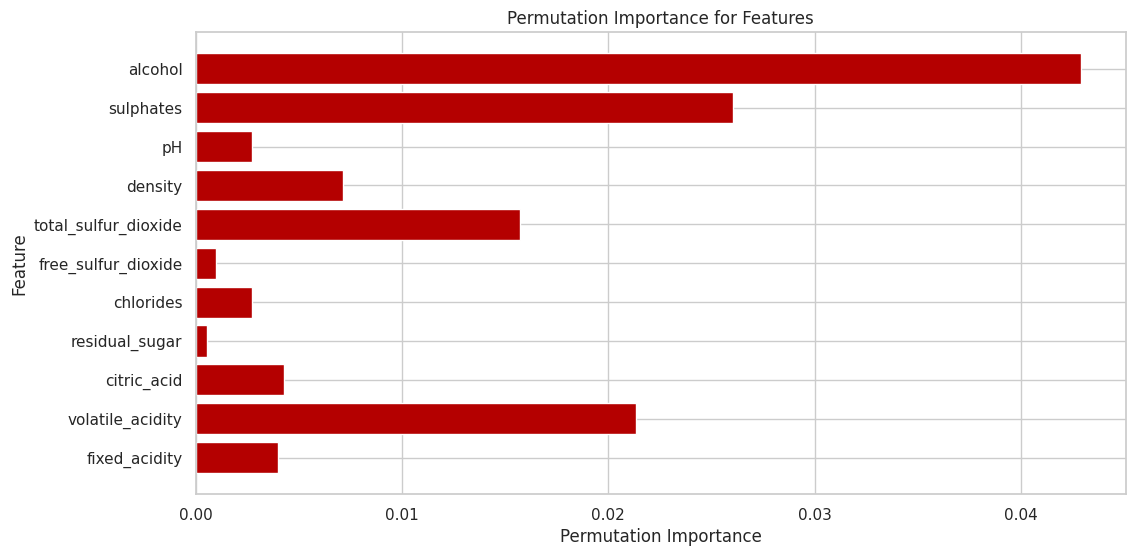

In [43]:
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=150,
    learning_rate=0.1,
    random_state=33
)

evaluate_model('AdaBoost Classifier', model)

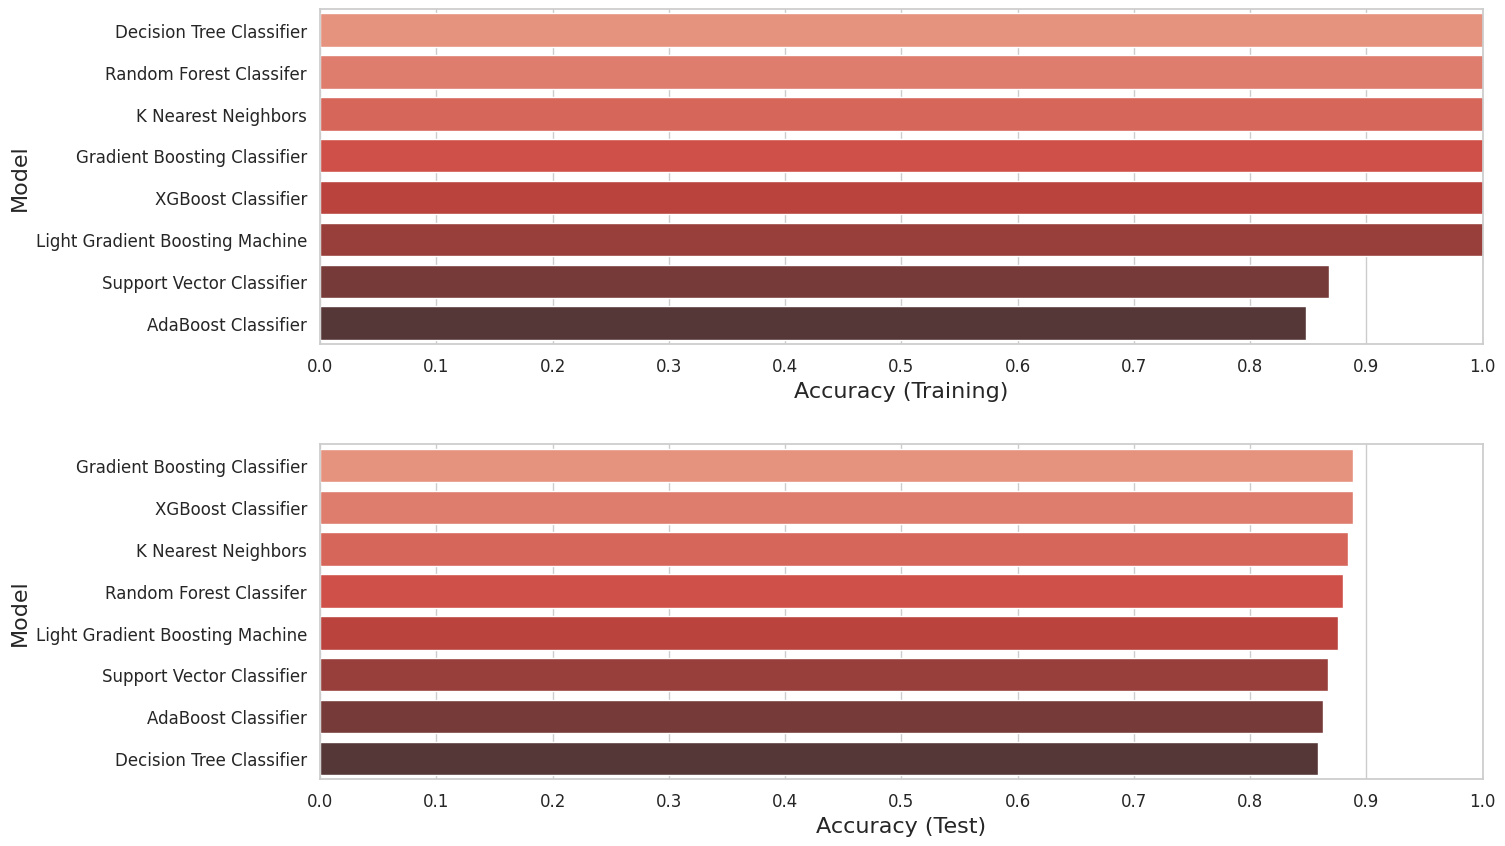

In [46]:
import pandas as pd


comparison = pd.DataFrame(models, columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Accuracy (Training)', 'Accuracy (Test)'])

# Plotting
plt.figure(figsize=(15, 10))


plt.subplot(2, 1, 1)
comparison.sort_values(by=['Accuracy (Training)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy (Training)', y='Model', data=comparison, palette='Reds_d')
plt.xlabel('Accuracy (Training)', size=16)
plt.ylabel('Model', size=16)
plt.xlim(0, 1.0)
plt.xticks(np.arange(0, 1.1, 0.1), size=12)
plt.yticks(size=12)


plt.subplot(2, 1, 2)
comparison.sort_values(by=['Accuracy (Test)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy (Test)', y='Model', data=comparison, palette='Reds_d')
plt.xlabel('Accuracy (Test)', size=16)
plt.ylabel('Model', size=16)
plt.xlim(0, 1.0)
plt.xticks(np.arange(0, 1.1, 0.1), size=12)
plt.yticks(size=12)


plt.subplots_adjust(hspace=0.3)
plt.show()


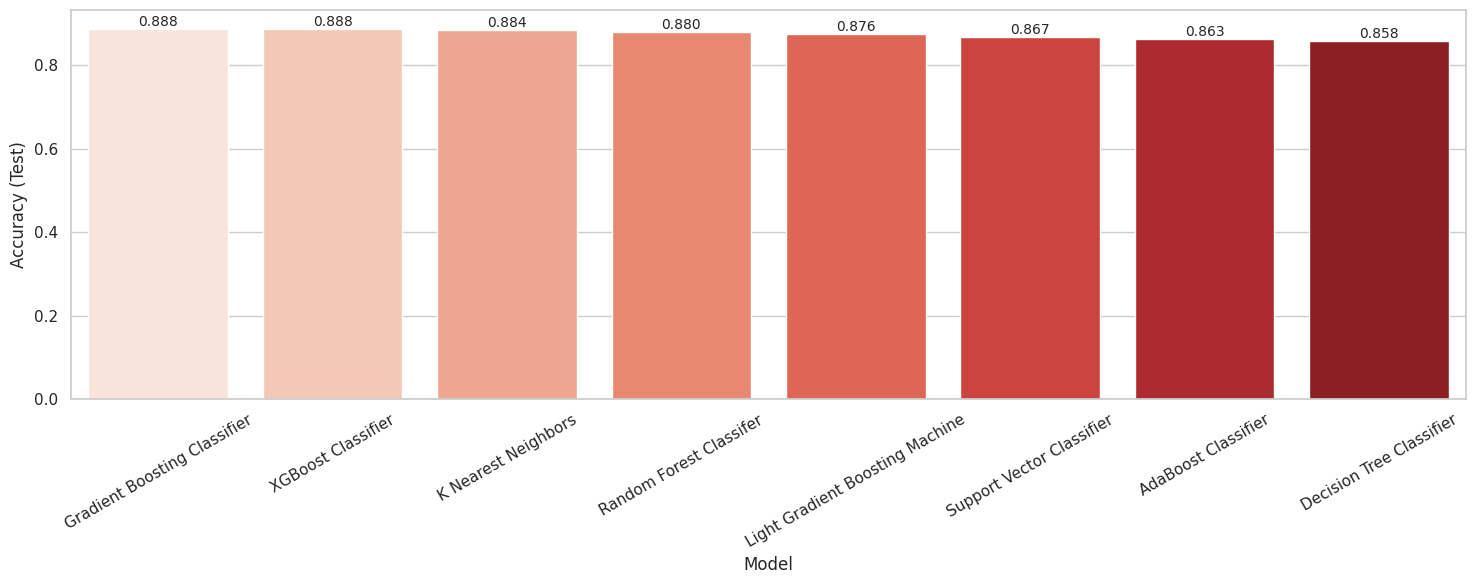

In [47]:

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

sns.barplot(x='Model', y='Accuracy (Test)', data=comparison, ax=ax, palette='Reds')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', size=10)

for label in ax.get_xticklabels():
    label.set_rotation(30)

plt.tight_layout()

plt.show()


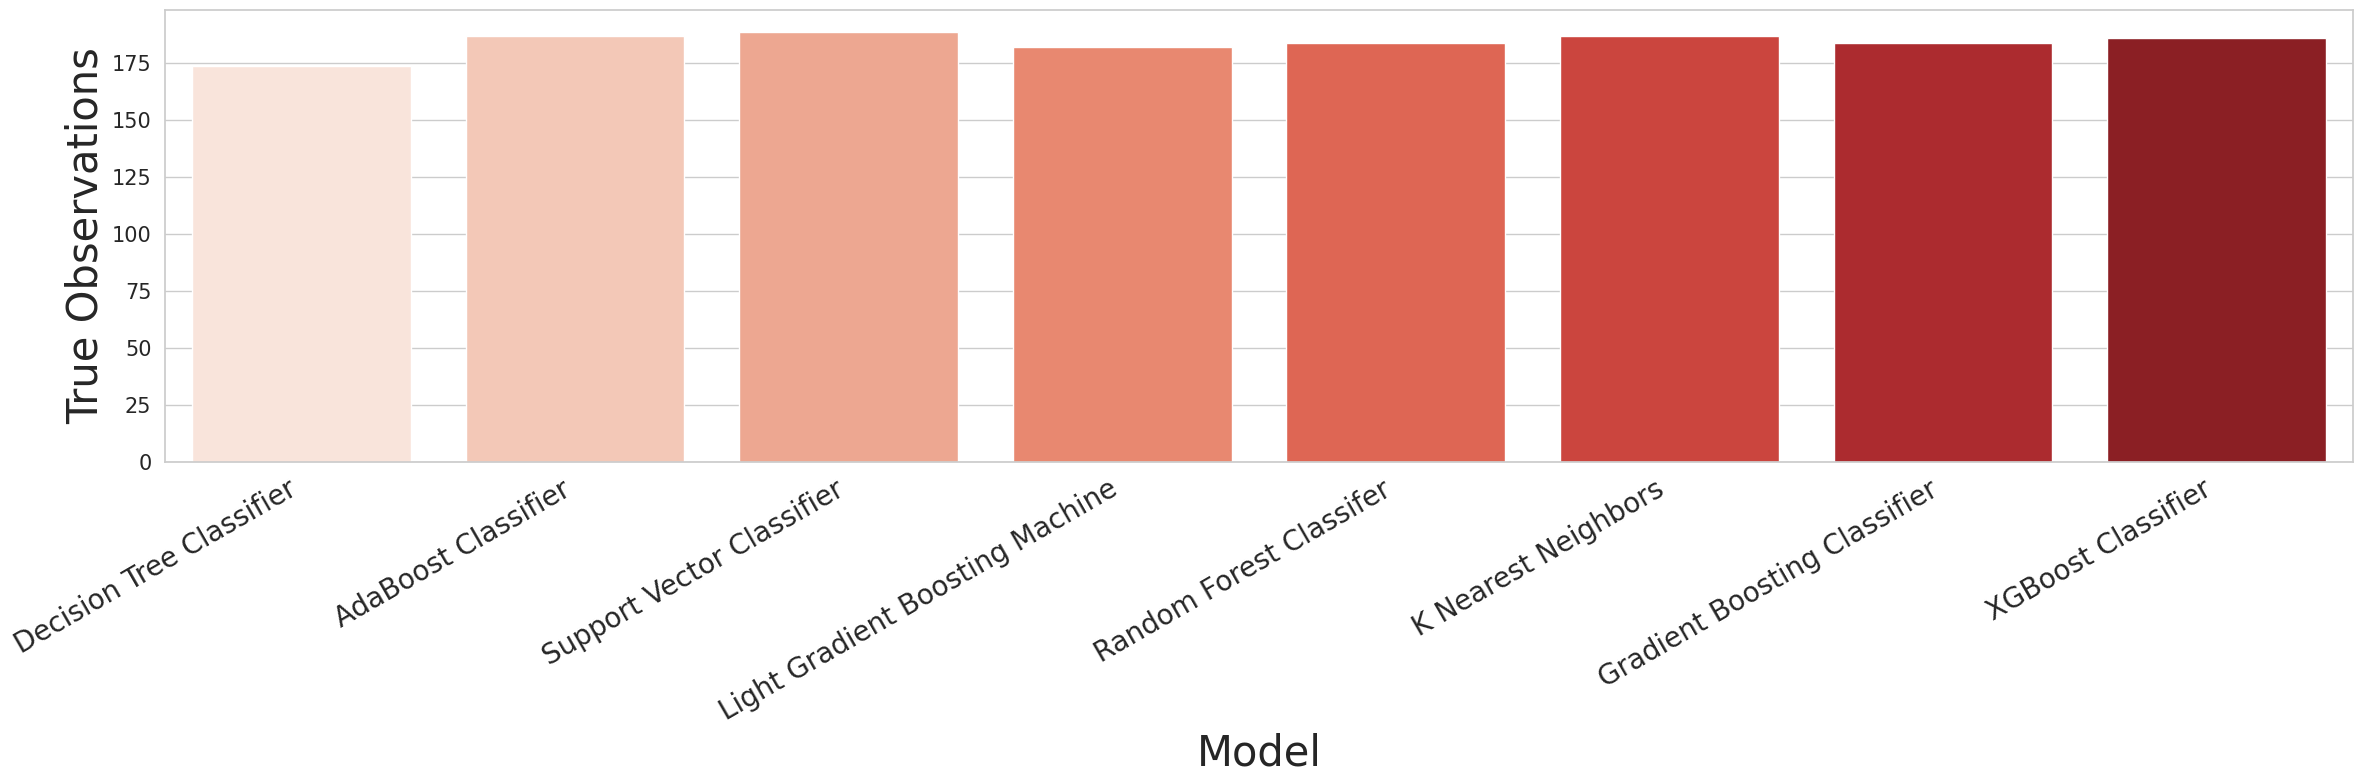

In [49]:

comparison = pd.DataFrame(models, columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Accuracy (Training)', 'Accuracy (Test)'])


plt.figure(figsize=(24, 8))


comparison.sort_values(by=['Accuracy (Test)'], ascending=True, inplace=True)


sns.barplot(x='Model', y=comparison['TP'] + comparison['TN'], palette='Reds', data=comparison)

plt.xlabel('Model', size=30)
plt.ylabel('True Observations', size=30)
plt.xticks(size=20, rotation=30, ha='right')
plt.yticks(size=15)

plt.tight_layout()
plt.show()